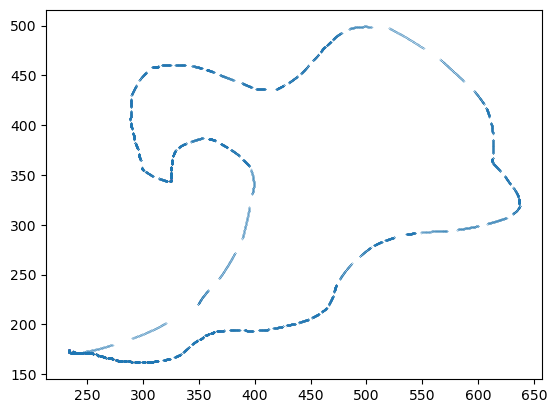

In [25]:
import xml.etree.ElementTree as ET 
import numpy as np

def read_svg(filename):
    namespace = {'svg': 'http://www.w3.org/2000/svg'}
    with open(filename, 'r') as f:
        xml_file = ET.parse(f)
        root_el = xml_file.getroot()
        paths = root_el.findall("svg:path", namespaces=namespace)
        return paths[0].attrib["d"]
    
curve_str = read_svg("Method Draw Vector.svg")

def get_point_lsts(curve_str):
    proxy = ""
    listilist = []
    for ch in curve_str:
        if ch.isalpha():
            if proxy != "":
                listilist.append(proxy)
            proxy = ""
        proxy += ch
    return listilist

plist = get_point_lsts(curve_str)
# print(plist)

def parse_cmd(cmd_str):
    if cmd_str[0] == "c":
        coord_str_list = cmd_str[1:].split(" ")
        coord_matrix = [list(map(float, coord.split(","))) for coord in coord_str_list]
        return { "controls" : list(coord_matrix) }
    return {"move" : list(map(float, cmd_str[1:].split(",")))}

all_commands = [parse_cmd(cmd) for cmd in plist]
all_commands

def function_generator(control_points):
    a, b, c = control_points
    x1, y1 = a
    x2, y2 = b
    x3, y3 = c
    return lambda t: [(x1 * (1-t)**2) + (2 * x2 * t * (1-t)) + (t**2 * x3), (y1 * (1-t)**2) + (2 * y2 * t * (1-t)) + (t**2 * y3)]

def offset_points(parr, curr):
    return [[point[0] + curr[0], point[1] + curr[1]] for point in parr]

def func_point_list(all_points):
    step_size = 0.01
    x_lst = []
    y_lst = []
    t_vals = np.arange(0, 1, step_size)
    
    org = all_points[0]["move"]

    for point in all_points[1:]:
        func = function_generator(offset_points(point["controls"], org))
        for t in t_vals:
            x,y = func(t)
            x_lst.append(x)
            y_lst.append(y)
        org = [x, y]
    return (x_lst, y_lst)
    
            
x_lst, y_lst = func_point_list(all_commands)

import matplotlib.pyplot as plt
plt.scatter(x_lst, y_lst, s=0.01, alpha=1.0)
plt.show()

In [43]:
def rotating_function_vector(n, radius, t):
    c = radius * np.exp(2j*np.pi * n * t)
    return [c.real, c.imag]

rotating_function_vector(1,1,1)

[1.0, -2.4492935982947064e-16]

In [86]:
def cmul(c1, c2):
    a,b = c1
    c,d = c2
    return [(a * c) - (b*d), (b*c) + (a*d)]

def bound_t(lst, t):
    L = len(lst) - 1
    idx = t * L
    return lst[int(idx)]
    

def numeric_integration(point_list, n):
    L = len(point_list)
    # bounds of integral: 0 - L
    riemann_sum = [0, 0]
    step_size = 0.01
    integration_domain = np.arange(0, 1, step_size)
    for t in integration_domain:
        val = cmul(bound_t(point_list, t), rotating_function_vector(-n, 1, t))
        riemann_sum[0] += val[0] * step_size
        riemann_sum[1] += val[1] * step_size
    return riemann_sum

coord_vecs = list(zip(x_lst, y_lst))

coeffs = [numeric_integration(coord_vecs, n) for n in range(len(coord_vecs))]